# NSW Electricity Demand Analysis
## Case Study 1: Daily, Weekly, Seasonal Demand Patterns

This notebook performs exploratory data analysis (EDA) on NSW operational demand data 
to understand daily cycles, weekly behaviour, and seasonal trends.

Dataset Source: AEMO Operational Demand (via Python library or uploaded dataset)
Region: NSW1
Timeframe: YYYY-YYYY (fill after loading data)


In [1]:
# Step 1: Import necessary library files and set up cache
import pandas as pd
from nemosis import dynamic_data_compiler
from datetime import datetime, timedelta
import os
from pymongo import MongoClient

# --- Cache Setup ---
# A temporary directory to store AEMO CSV files downloaded by nemosis
raw_data_cache_dir = "/tmp/nemosis_cache"
os.makedirs(raw_data_cache_dir, exist_ok=True)
print(f"Cache directory ensured: {raw_data_cache_dir}")

# --- AEMO Table Name ---
# We will use DISPATCHREGIONSUM for reliable regional demand data
table_name = "DISPATCHREGIONSUM"

# --- Date range setup ---
start_date = datetime(2024, 1, 1)
end_date = datetime(2025, 1, 1)
print(f"Data range defined from {start_date.date()} to {end_date.date()}")


Cache directory ensured: /tmp/nemosis_cache
Data range defined from 2024-01-01 to 2025-01-01


In [5]:
# Step 2: Connect to MongoDB
try:
    client = MongoClient("mongodb://localhost:27017/")
    # Access the database and collection
    db = client["AEMO_Data_Archive"]
    collection = db["NSW_Operational_Demand_2024"]
    
    # Optional: Check connection by listing existing collections
    print(f"Connected to MongoDB. Collections in 'AEMO_Data_Archive': {db.list_collection_names()}")
    print(f"Target collection is '{collection.name}'.")

except Exception as e:
    print(f"Failed to connect to MongoDB: {e}")
    print("Please ensure your MongoDB service (mongod) is running on localhost:27017.")
    # If connection fails, the script might stop here depending on your environment.


Connected to MongoDB. Collections in 'AEMO_Data_Archive': ['NSW_Operational_Demand_2024']
Target collection is 'NSW_Operational_Demand_2024'.


In [6]:
# Step 3: Loop through data month-by-month and ingest into MongoDB
current = start_date

print("\n--- Starting Data Ingestion Loop ---")

while current < end_date:
    # Calculate the next month's start and end dates accurately
    next_month = (current.replace(day=28) + timedelta(days=4)).replace(day=1)
    end_of_month = next_month - timedelta(seconds=1) 
    
    start_str = current.strftime("%Y/%m/%d %H:%M:%S")
    end_str = end_of_month.strftime("%Y/%m/%d %H:%M:%S")
    
    print(f"\nProcessing {start_str} → {end_str} for {table_name}...")

    try:
        df = dynamic_data_compiler(
            start_str,
            end_str,
            table_name,
            raw_data_cache_dir
        )
        
        # Filter for the NSW region using the verified 'REGIONID' column
        if 'REGIONID' in df.columns:
            df_nsw = df[df["REGIONID"] == "NSW1"].copy()
            
            if not df_nsw.empty:
                # Insert into MongoDB
                records = df_nsw.to_dict("records")
                result = collection.insert_many(records)
                print(f"Inserted {len(result.inserted_ids)} documents for NSW1 in {current.strftime('%B %Y')}.")
            else:
                print(f"No NSW1 specific data found for this period.")
        else:
            print(f"Error: 'REGIONID' column not found in the {table_name} data frame.")

        del df # Release memory
        
    except Exception as e:
        print(f"An error occurred while processing {current.strftime('%B %Y')}: {e}")
        # Continue to the next month even if one month fails
        pass

    current = next_month

print("\n--- Data ingestion complete! ---")


--- Starting Data Ingestion Loop ---

Processing 2024/01/01 00:00:00 → 2024/01/31 23:59:59 for DISPATCHREGIONSUM...
INFO: Compiling data for table DISPATCHREGIONSUM
INFO: Returning DISPATCHREGIONSUM.
Inserted 8927 documents for NSW1 in January 2024.

Processing 2024/02/01 00:00:00 → 2024/02/29 23:59:59 for DISPATCHREGIONSUM...
INFO: Compiling data for table DISPATCHREGIONSUM
INFO: Returning DISPATCHREGIONSUM.
Inserted 8351 documents for NSW1 in February 2024.

Processing 2024/03/01 00:00:00 → 2024/03/31 23:59:59 for DISPATCHREGIONSUM...
INFO: Compiling data for table DISPATCHREGIONSUM
INFO: Returning DISPATCHREGIONSUM.
Inserted 8927 documents for NSW1 in March 2024.

Processing 2024/04/01 00:00:00 → 2024/04/30 23:59:59 for DISPATCHREGIONSUM...
INFO: Compiling data for table DISPATCHREGIONSUM
INFO: Returning DISPATCHREGIONSUM.
Inserted 8639 documents for NSW1 in April 2024.

Processing 2024/05/01 00:00:00 → 2024/05/31 23:59:59 for DISPATCHREGIONSUM...
INFO: Compiling data for table DIS

In [7]:
cursor = collection.find({})
df = pd.DataFrame(list(cursor))

df.head()
df.info()
df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105408 entries, 0 to 105407
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   _id                          105408 non-null  object        
 1   SETTLEMENTDATE               105408 non-null  datetime64[ns]
 2   REGIONID                     105408 non-null  object        
 3   DISPATCHINTERVAL             105408 non-null  int64         
 4   INTERVENTION                 105408 non-null  int64         
 5   TOTALDEMAND                  105408 non-null  float64       
 6   AVAILABLEGENERATION          105408 non-null  float64       
 7   AVAILABLELOAD                105408 non-null  int64         
 8   DEMANDFORECAST               105408 non-null  int64         
 9   DISPATCHABLEGENERATION       105408 non-null  float64       
 10  DISPATCHABLELOAD             105408 non-null  float64       
 11  NETINTERCHANGE            

Index(['_id', 'SETTLEMENTDATE', 'REGIONID', 'DISPATCHINTERVAL', 'INTERVENTION',
       'TOTALDEMAND', 'AVAILABLEGENERATION', 'AVAILABLELOAD', 'DEMANDFORECAST',
       'DISPATCHABLEGENERATION', 'DISPATCHABLELOAD', 'NETINTERCHANGE',
       'EXCESSGENERATION', 'LOWER5MINLOCALDISPATCH', 'LOWER60SECLOCALDISPATCH',
       'LOWER6SECLOCALDISPATCH', 'RAISE5MINLOCALDISPATCH',
       'RAISE60SECLOCALDISPATCH', 'RAISE6SECLOCALDISPATCH', 'INITIALSUPPLY',
       'CLEAREDSUPPLY', 'LOWERREGLOCALDISPATCH', 'RAISEREGLOCALDISPATCH',
       'TOTALINTERMITTENTGENERATION', 'DEMAND_AND_NONSCHEDGEN', 'UIGF',
       'SEMISCHEDULE_CLEAREDMW', 'SEMISCHEDULE_COMPLIANCEMW'],
      dtype='object')

In [8]:
df.head()

,_id,SETTLEMENTDATE,REGIONID,DISPATCHINTERVAL,INTERVENTION,TOTALDEMAND,AVAILABLEGENERATION,AVAILABLELOAD,DEMANDFORECAST,DISPATCHABLEGENERATION,...,RAISE6SECLOCALDISPATCH,INITIALSUPPLY,CLEAREDSUPPLY,LOWERREGLOCALDISPATCH,RAISEREGLOCALDISPATCH,TOTALINTERMITTENTGENERATION,DEMAND_AND_NONSCHEDGEN,UIGF,SEMISCHEDULE_CLEAREDMW,SEMISCHEDULE_COMPLIANCEMW
0,691d5d11076fe491e49d2370,2024-01-01 00:05:00,NSW1,20231231241,0,6574.92,11471.00097,206,-43,6721.88,...,94.56,6656.50244,6617.53,119.47,49.0,71.11027,6688.64027,1489.00097,1489.00096,0.0
1,691d5d11076fe491e49d2371,2024-01-01 00:10:00,NSW1,20231231242,0,6651.09,11465.64305,206,-13,6899.12,...,95.00,6696.55273,6689.52,80.00,46.0,74.06938,6763.58938,1479.64305,1479.64305,0.0
2,691d5d11076fe491e49d2372,2024-01-01 00:15:00,NSW1,20231231243,0,6538.96,11475.74704,206,-19,6743.67,...,68.52,6609.41113,6580.48,129.00,84.0,70.96544,6651.44544,1491.74704,1491.74705,25.0
3,691d5d11076fe491e49d2373,2024-01-01 00:20:00,NSW1,20231231244,0,6497.99,11451.86425,206,-26,6516.20,...,149.46,6572.23486,6541.43,84.00,82.0,74.54208,6615.97208,1468.86425,1468.86425,0.0
4,691d5d11076fe491e49d2374,2024-01-01 00:25:00,NSW1,20231231245,0,6404.55,11435.88952,206,-32,6475.42,...,120.00,6485.48779,6443.89,90.00,34.0,81.72985,6525.61985,1452.88952,1452.88951,25.0


In [9]:
df_analysis = df[['SETTLEMENTDATE', 'TOTALDEMAND']]


In [10]:
df_analysis.head()

,SETTLEMENTDATE,TOTALDEMAND
0,2024-01-01 00:05:00,6574.92
1,2024-01-01 00:10:00,6651.09
2,2024-01-01 00:15:00,6538.96
3,2024-01-01 00:20:00,6497.99
4,2024-01-01 00:25:00,6404.55


In [11]:
df_analysis['SETTLEMENTDATE'] = pd.to_datetime(df_analysis['SETTLEMENTDATE'])

df_analysis['hour'] = df_analysis['SETTLEMENTDATE'].dt.hour
df_analysis['day'] = df_analysis['SETTLEMENTDATE'].dt.day
df_analysis['weekday'] = df_analysis['SETTLEMENTDATE'].dt.day_name()
df_analysis['month'] = df_analysis['SETTLEMENTDATE'].dt.month
df_analysis['month_name'] = df_analysis['SETTLEMENTDATE'].dt.month_name()
df_analysis['date'] = df_analysis['SETTLEMENTDATE'].dt.date


/var/folders/m8/cwx1pw8d7qs9k5mbrk0vzxz80000gn/T/ipykernel_11394/2550083282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analysis['SETTLEMENTDATE'] = pd.to_datetime(df_analysis['SETTLEMENTDATE'])
/var/folders/m8/cwx1pw8d7qs9k5mbrk0vzxz80000gn/T/ipykernel_11394/2550083282.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analysis['hour'] = df_analysis['SETTLEMENTDATE'].dt.hour
/var/folders/m8/cwx1pw8d7qs9k5mbrk0vzxz80000gn/T/ipykernel_11394/2550083282.py:4: SettingWithCopyWarning: 
A value is 

In [12]:
df_analysis.head()

,SETTLEMENTDATE,TOTALDEMAND,hour,day,weekday,month,month_name,date
0,2024-01-01 00:05:00,6574.92,0,1,Monday,1,January,2024-01-01
1,2024-01-01 00:10:00,6651.09,0,1,Monday,1,January,2024-01-01
2,2024-01-01 00:15:00,6538.96,0,1,Monday,1,January,2024-01-01
3,2024-01-01 00:20:00,6497.99,0,1,Monday,1,January,2024-01-01
4,2024-01-01 00:25:00,6404.55,0,1,Monday,1,January,2024-01-01


In [13]:
df_analysis['season'] = df_analysis['SETTLEMENTDATE'].dt.month % 12 // 3 + 1
df_analysis['season_name'] = df_analysis['season'].map({
    1: 'Summer',
    2: 'Autumn',
    3: 'Winter',
    4: 'Spring'
})


/var/folders/m8/cwx1pw8d7qs9k5mbrk0vzxz80000gn/T/ipykernel_11394/4130163483.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analysis['season'] = df_analysis['SETTLEMENTDATE'].dt.month % 12 // 3 + 1
/var/folders/m8/cwx1pw8d7qs9k5mbrk0vzxz80000gn/T/ipykernel_11394/4130163483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analysis['season_name'] = df_analysis['season'].map({


In [14]:
df_analysis.head()

,SETTLEMENTDATE,TOTALDEMAND,hour,day,weekday,month,month_name,date,season,season_name
0,2024-01-01 00:05:00,6574.92,0,1,Monday,1,January,2024-01-01,1,Summer
1,2024-01-01 00:10:00,6651.09,0,1,Monday,1,January,2024-01-01,1,Summer
2,2024-01-01 00:15:00,6538.96,0,1,Monday,1,January,2024-01-01,1,Summer
3,2024-01-01 00:20:00,6497.99,0,1,Monday,1,January,2024-01-01,1,Summer
4,2024-01-01 00:25:00,6404.55,0,1,Monday,1,January,2024-01-01,1,Summer


<Axes: xlabel='hour'>

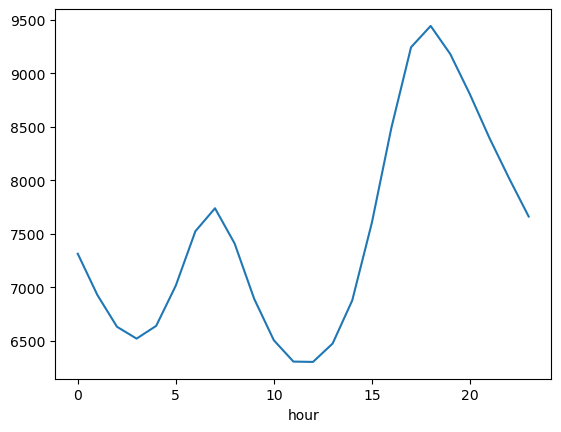

In [16]:
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105408 entries, 0 to 105407
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   SETTLEMENTDATE  105408 non-null  datetime64[ns]
 1   TOTALDEMAND     105408 non-null  float64       
 2   hour            105408 non-null  int32         
 3   day             105408 non-null  int32         
 4   weekday         105408 non-null  object        
 5   month           105408 non-null  int32         
 6   month_name      105408 non-null  object        
 7   date            105408 non-null  object        
 8   season          105408 non-null  int32         
 9   season_name     105408 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(4), object(4)
memory usage: 6.4+ MB
